In [75]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device_no = 3
torch.cuda.set_device(device_no)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [77]:
torch.cuda.is_available()

True

In [78]:
from opticaltomography.forward_inner import PhaseObject3D, Multislice
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss
from opticaltomography.utils import showimgstack

In [79]:
# Units in microns
wavelength = 0.6  # fluorescence wavelength/um
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 20  # Q：magnification's physical meaning?
# pixel_size = 6.5e-6 Q：pixel_size unit? If it is too small?
pixel_size = 4
na = 1
dx = pixel_size / mag
dy = dx
dz = dx * 3

dtype = torch.float32
np_dtype = np.float32

In [80]:
# import known input field from matlab file
# fx_illu_list: x position ex. 0.0041
# fy_illu_list: y position ex. -0.0146
# fz_illu_list: z layer    ex. 3
na_list = sio.loadmat("na_list_3D_rand_10.mat")
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.9   #paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.9
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0     #z layer at the z=0

In [81]:
# initial object, type: torch.float32
phantom = torch.zeros((200, 200, 25), dtype=dtype)

In [82]:
# ---------------------------#
# Setup solver objects
# ---------------------------#
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = True, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

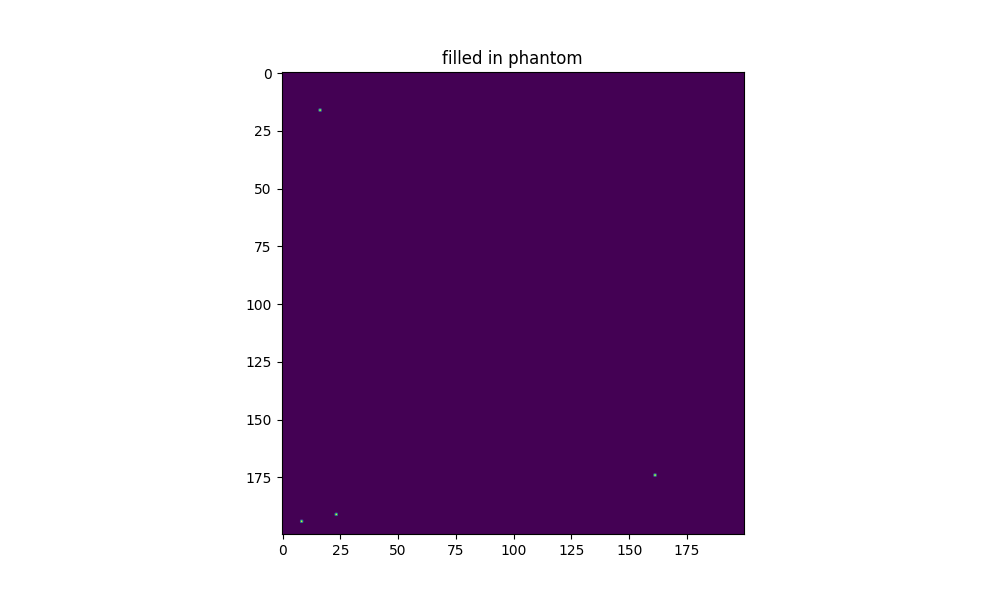

In [83]:
# ---------------------------#
# Fill in phantom
# ---------------------------#
# import the ground truth of the 3D object to generate forward measurements
phantom_coordinates = sio.loadmat("phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1

for i in range(25):
    solver_obj._x[:,:,i] = torch.fft.ifftshift(solver_obj._x[:,:,i])

# Show object
filled_phantom = np.array(solver_obj._x)
filled_phantom_show = np.real(filled_phantom.transpose(2, 0, 1))

f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []


def init():
    frames.append(axes.imshow(np.real(filled_phantom.transpose(2, 0, 1)[0])))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(np.real(filled_phantom.transpose(2, 0, 1)[i]))

interact(updateFrames, i=IntSlider(min=0, max=99, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=24), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

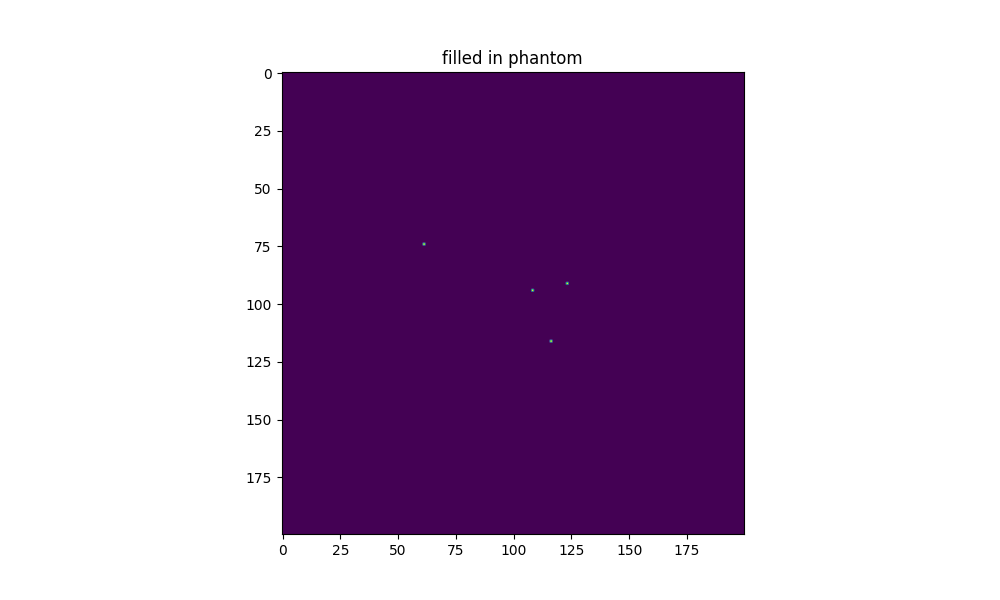

In [84]:
# ---------------------------#
# Show forward prediction
# ---------------------------#
# forward_field_mb[0].shape

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(np.fft.fftshift(solver_obj._x[:, :, 0])))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(np.fft.fftshift(solver_obj._x[:, :, i]))

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))

In [85]:
# ---------------------------#
# Generate forward prediction
# ---------------------------#
forward_field_mb, fields = solver_obj.forward(obj=solver_obj._x)

Text(0.5, 1.0, 'added up all the slices of target phase object (projection)')

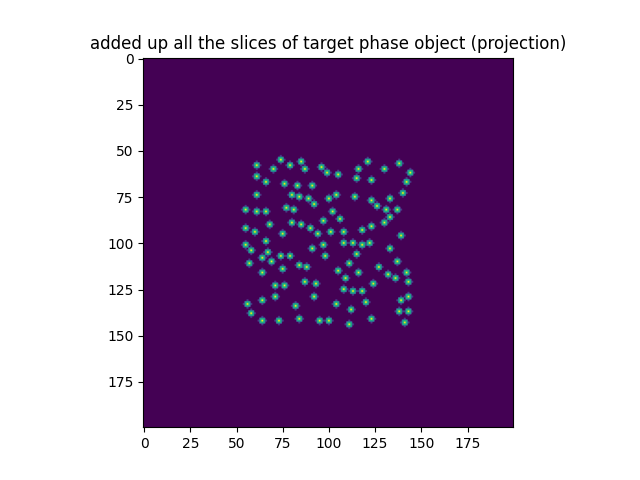

In [86]:
obj_show = np.zeros([200,200])
for i in range(25):
    obj_show += filled_phantom[:,:,i]

plt.figure()
plt.imshow(np.fft.fftshift(obj_show))
plt.title('added up all the slices of target phase object (projection)')

Text(0.5, 1.0, 'profile along red line')

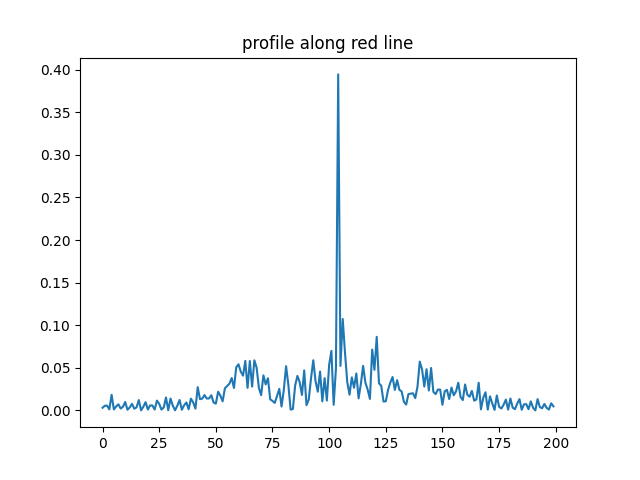

In [87]:
# plot = forward_field_mb[0,:,104]
plot = torch.fft.fftshift(forward_field_mb[0])[87,:]
plt.figure()
plt.plot(plot)
plt.title('profile along red line')

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

tensor(455.5170)
torch.Size([200, 200])


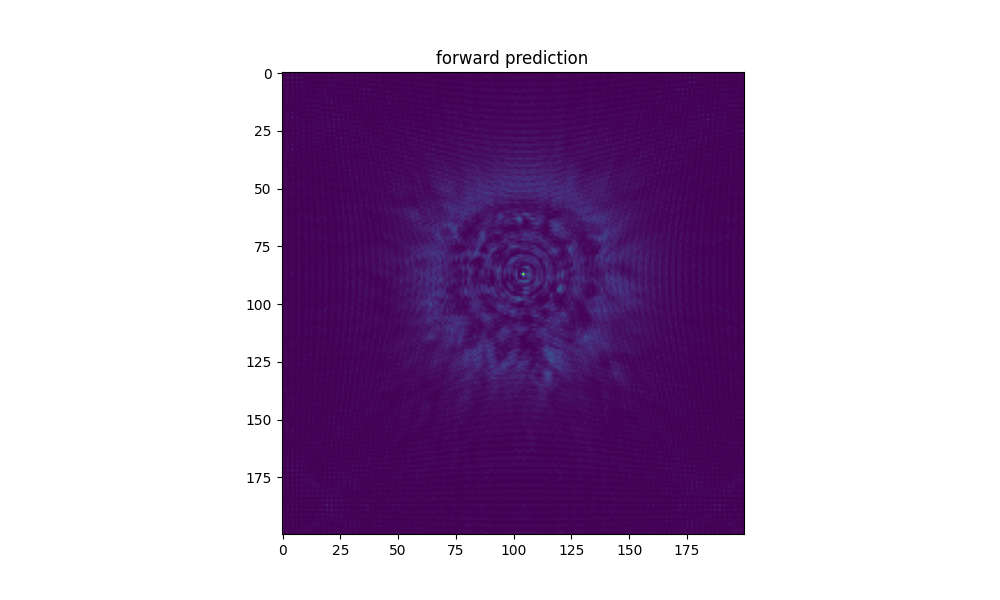

In [89]:
# ---------------------------#
# Show forward prediction
# ---------------------------#
# forward_field_mb[0].shape

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes.imshow(forward_field_mb[0]))
    axes.set_title('forward prediction')

init()

def updateFrames(i):
    # img = torch.fft.fftshift(torch.abs(solver_obj.test_spherical[i]))
    #frames.append(axes.imshow(img))
    frames[0].set_data(torch.fft.fftshift(forward_field_mb[i]))

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))
print(torch.sum(forward_field_mb[0]))
print(forward_field_mb[0].shape)

In [90]:
"""
plt.clf()
img = torch.log(forward_field_mb[0])
plt.imshow(img)
plt.title('measurement at camera plane (log)')
plt.colorbar()
plt.show()
"""

"\nplt.clf()\nimg = torch.log(forward_field_mb[0])\nplt.imshow(img)\nplt.title('measurement at camera plane (log)')\nplt.colorbar()\nplt.show()\n"

In [ ]:
# ---------------------------#
# Test Reconstruction
# ---------------------------#
X = torch.zeros_like(solver_obj._x, dtype=dtype, requires_grad=True, device=device)
for source_num in range(solver_obj.number_illum):
    forward_field_mb[source_num] = forward_field_mb[source_num].to(device)

n_iters = 2000
learning_rate = 1e3
optimizer = torch.optim.SGD([X], lr=learning_rate, momentum=0.9)
#f = plt.figure(1)


losslist = []

for epoch in range(n_iters):
    loss = 0
    optimizer.zero_grad()
    pred_forward, _ = solver_obj.forward(obj=X, device=device)
    for source_num in range(solver_obj.number_illum):
        loss += mse_loss(pred_forward[source_num], forward_field_mb[source_num])
    loss += total_variation_loss(X, 1e-2)

    loss_save = loss.cpu().detach().numpy()
    losslist.append(loss)
    
    loss.backward()
    optimizer.step()
    with torch.no_grad():

        # img = X[:, :, 10].cpu().detach().numpy()
        # imglist.append(img)
        # plt.imshow(img)
        # plt.title(f'Reconstruction after iteration {epoch}, loss {loss:.4e}')
        # plt.axis('off')
        # display.display(f)
        # display.clear_output(wait=True)

        print(f'Reconstruction after iteration {epoch}, loss {loss:.4e}')

Reconstruction after iteration 0, loss 3.2561e-04
Reconstruction after iteration 1, loss 2.3687e-04
Reconstruction after iteration 2, loss 1.3805e-04
Reconstruction after iteration 3, loss 1.0439e-04
Reconstruction after iteration 4, loss 9.3997e-05
Reconstruction after iteration 5, loss 8.6680e-05
Reconstruction after iteration 6, loss 8.3743e-05
Reconstruction after iteration 7, loss 7.7968e-05
Reconstruction after iteration 8, loss 6.9940e-05
Reconstruction after iteration 9, loss 6.5551e-05
Reconstruction after iteration 10, loss 6.2218e-05
Reconstruction after iteration 11, loss 5.5708e-05
Reconstruction after iteration 12, loss 5.2059e-05
Reconstruction after iteration 13, loss 4.8239e-05
Reconstruction after iteration 14, loss 4.3211e-05
Reconstruction after iteration 15, loss 3.9000e-05
Reconstruction after iteration 16, loss 3.6176e-05
Reconstruction after iteration 17, loss 3.2943e-05
Reconstruction after iteration 18, loss 2.9640e-05
Reconstruction after iteration 19, loss 2

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

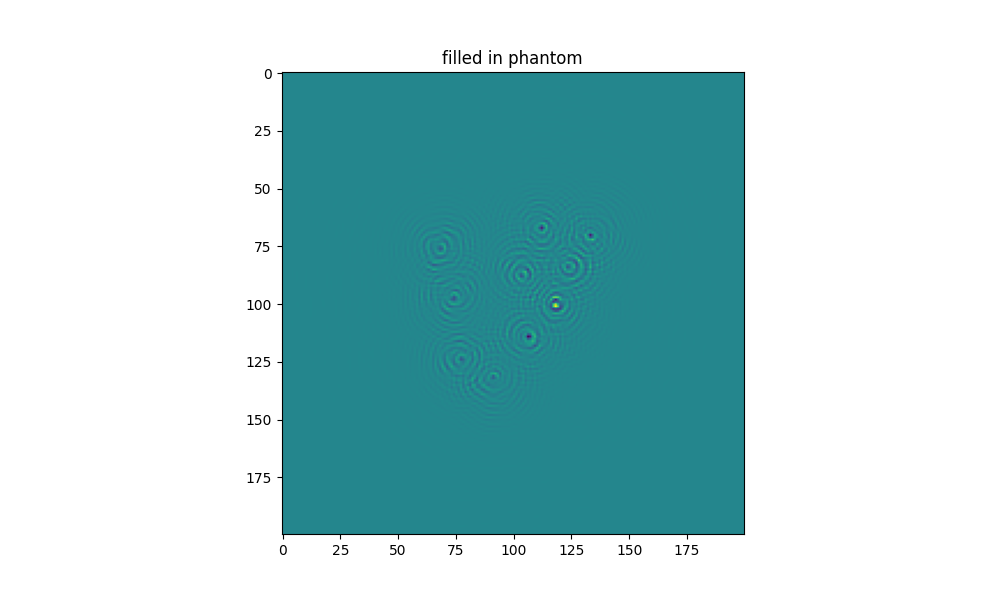

In [165]:
# ---------------------------#
# Show forward prediction
# ---------------------------#
# forward_field_mb[0].shape

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(X[:, :, 0].cpu().detach().numpy()))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(X[:, :, i]).cpu().detach().numpy())

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))

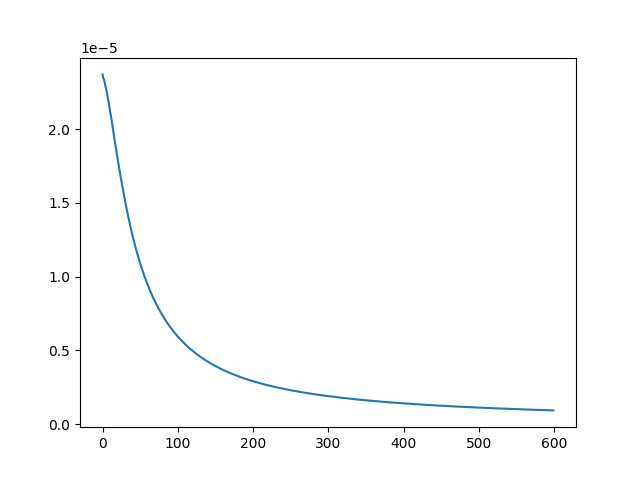

In [14]:
plt.figure()
loss_show = []
for i in range(600):
    loss_show.append(losslist[i].detach().numpy())
plt.plot(loss_show)

In [15]:
np.save('Data/0227/loss_list_600epoch_mse_tv_1e-2_num10_range0.05_z0_300x300',loss_show)

In [16]:
np.save('Data/0227/output_600epoch_mse_tv_1e-2_num10_range0.05_z0_300x300',X.cpu().detach().numpy())

In [ ]:
X.detach().numpy()